# Is Brl1 a chaperone?

In this notebook, we use the 10-handle KARMA labeling data and combine it with data for Brl1 (which was one of the original 10 handles).
We try to find assembly trees that fit the data, where Brl1 is a unique protein in the sense that it binds and unbinds from the complex at
two different points.

In [1]:
from typing import Tuple
import pandas as pd
from scipy.optimize import curve_fit
from scipy.linalg import expm
import scipy.stats
import os
from tqdm import tqdm
import seaborn as sns
from uncertainties import ufloat, nominal_value, std_dev, unumpy
import numpy as np
import matplotlib.pyplot as plt
import json
import itertools

from karma import RES_DIR, DATA_DIR, AssemblyTree
from karma.fit_pools import load_phis
from karma.dynamic_tree import DynamicAssemblyTree
from karma.ksm import f_target

from matplotlib.backends.backend_pdf import PdfPages
from pynverse import inversefunc

# Set plotting style
sns.set_style("ticks")
from matplotlib import rc
rc('font',**{'family': 'sans-serif'})
rc('text', usetex=False)

NEW_RES_DIR = RES_DIR / "brl1_dynamic"
if not os.path.exists(NEW_RES_DIR):
    os.mkdir(NEW_RES_DIR)
    
KARMA_10_HANDLE_DATA_FILE = os.path.join(DATA_DIR, "2020-02-01_10Handles_ZZ_K1_NUP_NTR_NTR-like_labeling.tsv")
KARMA_BRL1_DATA_FILES = [
    os.path.join(DATA_DIR, "2021-07-28_BRL1_Timecourse_NUPsNTRs_metabolicLabeling.tsv"),
    os.path.join(DATA_DIR, "2021-08-30_BRL1Labeling_10HandlePD.tsv"),
]

# Step 1: Run the KSM for all data (including Brl1)

In [2]:
# we use the result from the previous KARMA assays, asusming that the lysine pool size hasn't changed
LYSINE_PSI = 0.35

GROWTH_RATE = 0.0078  # 1/min
MIN_PHI = 1e-3
MAX_TIME = 150

def f_target(
    t: np.ndarray,
    phi: np.ndarray,
    index: int,
) -> np.ndarray:
    """
        Calculate the expected target pool (S2) labeling for a protein
        in an exponentially growing cell with growth rate μ.
                
        Arguments:
            t - time (in minutes)
            phi - the parameters of the pools (starting with the precusros pool)
            index - the index of the target pool
    """
    inv_phi = [1.0/p for p in phi.flat]
    M = np.diag(inv_phi[1:], k=1) - np.diag(inv_phi)
    
    if type(t) == float:
        res = expm(M * GROWTH_RATE * t)[:, index].sum()
        return 1.0 - res  # return a float as well
    else:
        res = np.array([expm(M * x)[:, index].sum() for x in (GROWTH_RATE * t).flat])
        return 1.0 - res  # return an array with the same shape as 't'

In [3]:
# internal reference proteins behave as 2-step systems with a phi = LYSINE_PSI,
# so we can use the same function for them
f_timers = lambda t: f_target(t, np.array([LYSINE_PSI, 1]), index=1)
f_timers_inverse = inversefunc(f_timers, domain=[0, MAX_TIME], open_domain=False)

In [4]:
def fit_phis(xdata: np.ndarray, ydata: np.ndarray, inaccessible=True):

    def f_without_inaccessible(tdata: np.ndarray, phi1: float):
        return f_target(tdata, np.array([LYSINE_PSI, phi1, 1]), index=2)
    
    def f_with_inaccessible(tdata: np.ndarray, phi1_phi2: float, z: float = 1.0):
        """
            when z = 0, both phi1 and phi2 are equal (phi1 = phi2 = sqrt(phi1_phi2))
            when z = 1, phi2 will be equal to 1 (phi1 = phi1_phi2)
        """
        phi1 = np.sqrt(phi1_phi2 * (1 - z + z*phi1_phi2))
        phi2 = np.sqrt(phi1_phi2 / (1 - z + z*phi1_phi2))
        return f_target(tdata, np.array([LYSINE_PSI, phi1, phi2]), index=2)

    if inaccessible:
        popt, pcov = curve_fit(f_with_inaccessible, xdata=xdata, ydata=ydata, p0=(0.5, 0.5), bounds=[(MIN_PHI, 0), (1, 1)])
        mse = np.mean( (ydata - f_with_inaccessible(xdata, *popt))**2 )
        phi1 = np.sqrt(popt[0] * (1 - popt[1] + popt[1]*popt[0]))
        phi2 = np.sqrt(popt[0] / (1 - popt[1] + popt[1]*popt[0]))
        phi1_phi2_std = np.sqrt(pcov[0, 0])
        phi1_std = phi1_phi2_std / phi2
        phi2_std = 0.0
    else:
        popt, pcov = curve_fit(f_without_inaccessible, xdata=xdata, ydata=ydata, p0=(0.5), bounds=[MIN_PHI, 1])
        mse = np.mean( (ydata - f_without_inaccessible(xdata, *popt))**2 )
        phi1 = popt[0]
        phi1_std = np.sqrt(pcov[0, 0])
        phi2 = 1.0
        phi2_std = 0.0

    phi = unumpy.uarray([phi1, phi2], [phi1_std, phi2_std])
    return phi, mse

def calculate_phis(data_df: pd.DataFrame) -> Tuple[pd.DataFrame, plt.Figure]:
    n_baits = len(data_df.bait.unique())
    n_preys = len(data_df.prey.unique())
    phi_data = []
    
    with tqdm(total=n_preys*n_baits) as pbar:
        for bait, bgroup_df in data_df.groupby("bait"):
            pbar.set_description(f"Processing bait {bait}")
            for prey, pgroup_df in bgroup_df.groupby("prey"):
                if pgroup_df.k1.mean() > pgroup_df.timer_k1.mean():
                    # fit with an inaccessible pool, i.e. ln(phi2) lower bound is MIN_PHI
                    phi, mse = fit_phis(pgroup_df.t.values, pgroup_df.k1.values, inaccessible=True)
                    phi_data.append((bait, prey, phi[0], phi[1], mse))
                else:
                    # fit without an inaccessible pool, i.e. ln(phi2) lower bound is 1
                    phi, mse = fit_phis(pgroup_df.t.values, pgroup_df.k1.values, inaccessible=False)
                
                    phi_data.append((bait, prey, phi[0], ufloat(1, 0), mse))
                pbar.update(1)

    return pd.DataFrame(data=phi_data,
                        columns=["bait", "prey", "phi1", "phi2", "mse"])

def plot_ksm_fits(data_df: pd.DataFrame, ksm_df: pd.DataFrame, bait: str, prey: str, ax: plt.Axes):
    t_range = np.linspace(0, MAX_TIME, 25)

    group_data_df = data_df.loc[(data_df.bait == bait) & (data_df.prey == prey), :]
    phi1, phi2, mse = ksm_df.set_index(["bait", "prey"]).loc[(bait, prey), :]
    phi_nom = np.array([LYSINE_PSI, phi1.nominal_value, phi2.nominal_value])

    ax.plot(t_range, 1.0 - np.exp(-t_range*GROWTH_RATE), color=sns.xkcd_rgb["windows blue"],
            label=r"$1 - e^{-\mu t}$", linewidth=1, zorder=1)
    ax.plot(t_range, f_timers(t_range), linewidth=1, 
            color=sns.xkcd_rgb["coral"], label="reference", zorder=1)
    for row in group_data_df.itertuples():
        ax.plot([row.t, row.t], [row.k1, row.timer_k1], linewidth=0.5, color=sns.xkcd_rgb["coral"], label=None, zorder=1)

    ax.scatter(x=group_data_df.t,
               y=group_data_df.k1,
               color=sns.xkcd_rgb["amethyst"],
               label=f"prey: {prey}", zorder=2)

    ax.plot(t_range, f_target(t_range, phi_nom, index=2), color=sns.xkcd_rgb["amethyst"], linewidth=2,
            label=f"$\phi_1$ = {phi1:.1g}, $\phi_2$ = {phi2.nominal_value:.1g}", zorder=2)

    ax.set_xlabel("time (min)")
    ax.set_ylabel("$K_1$ labeling")
    ax.legend(fontsize=7, frameon=False)

def plot_all_ksm_fits(figure_fname: str, data_df: pd.DataFrame, ksm_df: pd.DataFrame, n_cols: int=4):
    baits = sorted(data_df.bait.unique())
    preys = sorted(data_df.prey.unique())
    n_rows = int(np.ceil(len(preys)/n_cols))

    with tqdm(total=ksm_df.shape[0]) as pbar:
        with PdfPages(figure_fname) as pdf:
            for bait in baits:
                fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*3.5), sharex="all", sharey="all")
                for ax, prey in zip(axs.flat, preys):
                    pbar.set_description(f"Plotting KSM fits for {bait}-{prey}")
                    plot_ksm_fits(data_df, ksm_df, bait, prey, ax=ax)
                    pbar.update(1)
                fig.suptitle(f"bait: {bait}")
                pdf.savefig(fig)
                plt.close(fig)

In [5]:
def calculate_clustered_labeling_data(_df, clusters):
    timer_df = _df[_df.prey.isin(["KAP95", "MEX67", "KAP123"])].groupby(["bait", "time", "replicate"]).mean()[["k1"]]
    timer_df.rename(columns={"k1": "timer_k1"}, inplace=True)
    timer_df["t"] = timer_df.timer_k1.apply(f_timers_inverse)
    _df = _df[_df.kind != "NTR"]

    # drop the following baits: NSP1, GLE1, NDC1
    _df = _df[~_df.bait.isin(["NSP1", "GLE1", "NDC1"])]

    _df["cluster"] = ""
    for k, v in clusters.items():
        _df.loc[_df.prey.isin(v), "cluster"] = k

    # drop data of preys that are in none of the clusters
    _df = _df[_df.cluster != ""]
    _df.drop("prey", axis=1, inplace=True)
    _df.rename(columns={"cluster": "prey"}, inplace=True)

    # calculate mean and stdev for each cluster-bait pair (and also across the 3
    # replicates at the same time)
    clustered_data_df = _df.groupby(["bait", "prey", "time", "replicate"]).agg(["mean", "std"])[["k1"]]
    clustered_data_df.columns = ["k1", "k1_std"]
    clustered_data_df = clustered_data_df.reset_index().join(timer_df, on=["bait", "time", "replicate"])
    return clustered_data_df

In [6]:

CLUSTERS_WITH_BRL1 = {
    "MLP1": ["MLP1"],
    "*MLP2": ["MLP2"],
    "NUP1": ["NUP1"],
    "NUP57": ["NUP49", "NUP57"],
    "*NUP53": ["NUP53", "NUP170", "POM152", "POM34"],
    "NUP82": ["NUP82", "NUP159"],
    "NUP84": ["NUP84", "NUP133", "NUP145C"],
    "NUP85": ["NUP85", "NUP120"],
    "NUP188": ["NUP188"],
    "BRL1": ["BRL1"],
}
karma_10_handle_df = pd.read_csv(KARMA_10_HANDLE_DATA_FILE, delimiter="\t")

karma_combined_df = pd.concat([karma_10_handle_df] + [
    pd.read_csv(fname, delimiter="\t") for fname in KARMA_BRL1_DATA_FILES
])
clustered_data_df = calculate_clustered_labeling_data(karma_combined_df, CLUSTERS_WITH_BRL1)

In [7]:
clustered_data_df = clustered_data_df[clustered_data_df.bait != "NUP159"]

In [8]:
# Run the KSM fitting and plot the results
clustered_ksm_df = calculate_phis(clustered_data_df)
figure_fname = NEW_RES_DIR / "clusters_ksm_fits_with_Brl1.pdf"
plot_all_ksm_fits(figure_fname, clustered_data_df, clustered_ksm_df, n_cols=3)

Plotting KSM fits for NUP85-NUP85: 100%|████████████████████████████████████████████████| 90/90 [00:09<00:00,  9.49it/s]


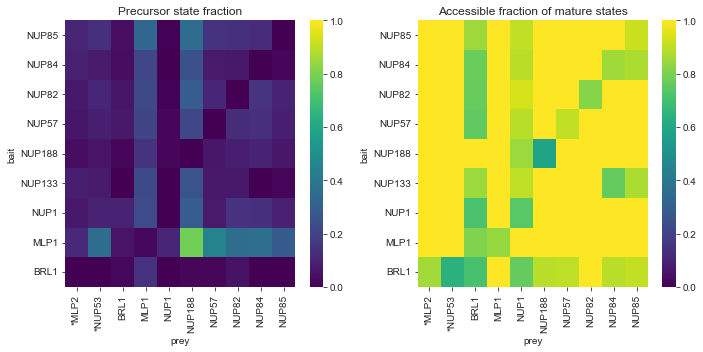

In [9]:
_df = clustered_ksm_df.copy()

DOUBLING_TIME = np.log(2) / GROWTH_RATE
maturation_time = DOUBLING_TIME * _df.phi1 / (1.0 - _df.phi1)
maturation_rate = GROWTH_RATE * (1.0/_df.phi1 - 1.0)

_df["Precursor state fraction"] = _df.phi1.apply(nominal_value)
_df["Precursor state fraction uncertainty"] = _df.phi1.apply(std_dev)
_df["Accessible fraction of mature states"] = _df.phi2.apply(nominal_value)
_df["Maturation time [min]"] = maturation_time.apply(nominal_value)
_df["Maturation time [min] uncertainty"] = maturation_time.apply(std_dev)
_df["Maturation rate [1/min]"] = maturation_rate.apply(nominal_value)
_df["Maturation rate [1/min] uncertainty"] = maturation_rate.apply(std_dev)

_df.drop(["phi1", "phi2", "mse"], axis=1, inplace=True)
_df.round(4).to_csv(NEW_RES_DIR / "clusters_ksm_fits_with_Brl1.csv", index=None)

# plot a heatmap of all fits
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
vmin = 0
for ax, col in zip(axs.flat, ["Precursor state fraction", "Accessible fraction of mature states"]):
    pivot_df = _df.pivot("bait", "prey", col)
    sns.heatmap(pivot_df, ax=ax, cmap="viridis", vmin=0, vmax=1)
    ax.set_ylim(0, pivot_df.shape[0])
    ax.set_title(col)

fig.tight_layout()
fig.savefig(NEW_RES_DIR / "clusters_ksm_heatmap_with_Brl1.svg")

# Step 2: use the top tree from the original KARMA fit (without Brl1) and fit a dynamic tree to it

In [10]:
ref_phi_df, preys, baits = load_phis(NEW_RES_DIR / "clusters_ksm_fits_with_Brl1.csv")


TREE_JSON_FNAME = RES_DIR / "intermixing" / "all_trees_2020-06-16_22:43:43_top_2027.json"

with open(TREE_JSON_FNAME, "r") as fp:
    res_json = json.load(fp)

In [11]:
best_tree = AssemblyTree.from_json(res_json["trees"][0]["assembly_tree"])
best_tree.params["lysine_psi"] = LYSINE_PSI

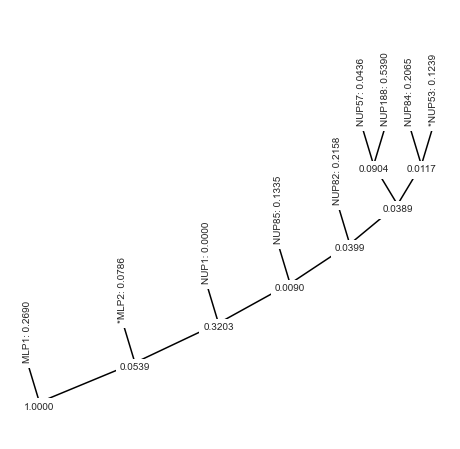

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
best_tree.plot_tree(ax)

Text(0.5, 1.0, 'observed labeling')

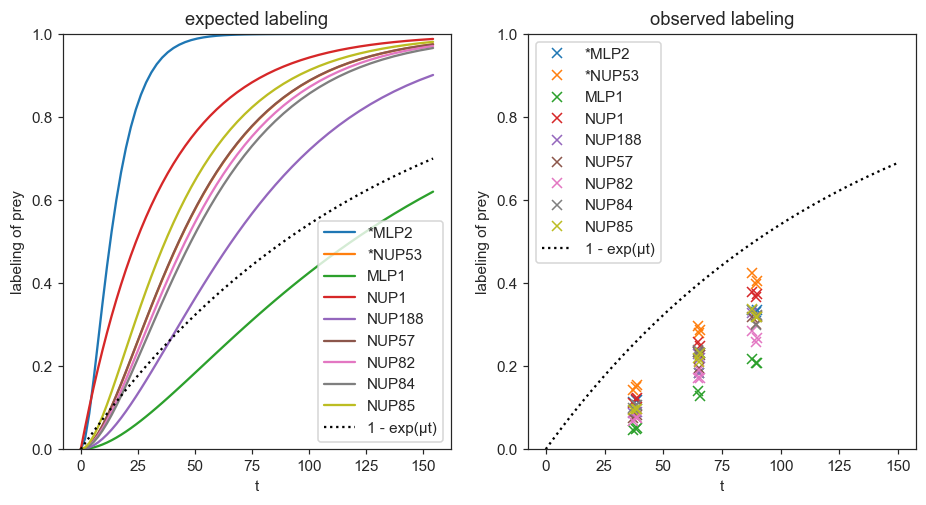

In [13]:
exit_node = best_tree.root
entry_node = exit_node.right.left.right.right
dynamic_tree = DynamicAssemblyTree(best_tree, entry_node, 1.0, exit_node, 0.0)

b_range = np.linspace(0, 0.7, 50)
f_dicts = [dynamic_tree.labeling(b) for b in b_range]
pred_labeling_df = pd.DataFrame.from_records(f_dicts)

t = -np.log(1.0 - b_range) / GROWTH_RATE
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=110)
ax = axs[0]
ax.plot(t, pred_labeling_df, label=pred_labeling_df.columns)
ax.plot(t, b_range, "k:", label="1 - exp(μt)")
ax.legend()
ax.set_xlabel("t")
ax.set_ylabel("labeling of prey")
ax.set_ylim(0, 1)
ax.set_title("expected labeling")

obs_labeling_df = clustered_data_df.loc[clustered_data_df.bait == "BRL1", ["prey", "k1", "t"]]
ax = axs[1]
for prey, group_df in obs_labeling_df.groupby("prey"):
    if prey == "BRL1":
        continue
    ax.plot(group_df.t, group_df.k1, 'x', label=prey)

t = np.linspace(0, MAX_TIME, 100)
ax.plot(t, 1.0 - np.exp(-GROWTH_RATE * t), "k:", label="1 - exp(μt)")
ax.legend()
ax.set_xlabel("t")
ax.set_ylabel("labeling of prey")
ax.set_ylim(0, 1)
ax.set_title("observed labeling")


# Use the tree model and poolsizes to precisedly calculate the labeling fractions each prey in each node

then, simulate a pulldown by finding all the nodes that have both bait and prey, and then calculating a weighted average of the labeling fractions to get the expected labeling of the prey in the pulldown.

In [14]:
colormap = {
    "NUP85": "#bd42ff",
    "NUP84": "#ef0052",
    "NUP145C": "#ef0052",
    "NUP133": "#ef0052",
    "*NUP53": "#ff9400",
    "NUP82": "#5aa518",
    "NUP159": "#5aa518",
    "NUP57": "#5aa5c6",
    "NUP49": "#5aa5c6",
    "NUP188": "#4200ff",
    "MLP1": "#bdbdbd",
    "*MLP2": "#ff8080",
    "NUP1": "#a99480",
    "BRL1": "#666666",
}

In [16]:
t_range = -np.log(1.0 - b_range) / GROWTH_RATE

labeling_with_baits_df = best_tree.get_labeling_predictions(b_range)
labeling_with_baits_df["time"] = -np.log(1.0 - labeling_with_baits_df.b) / GROWTH_RATE

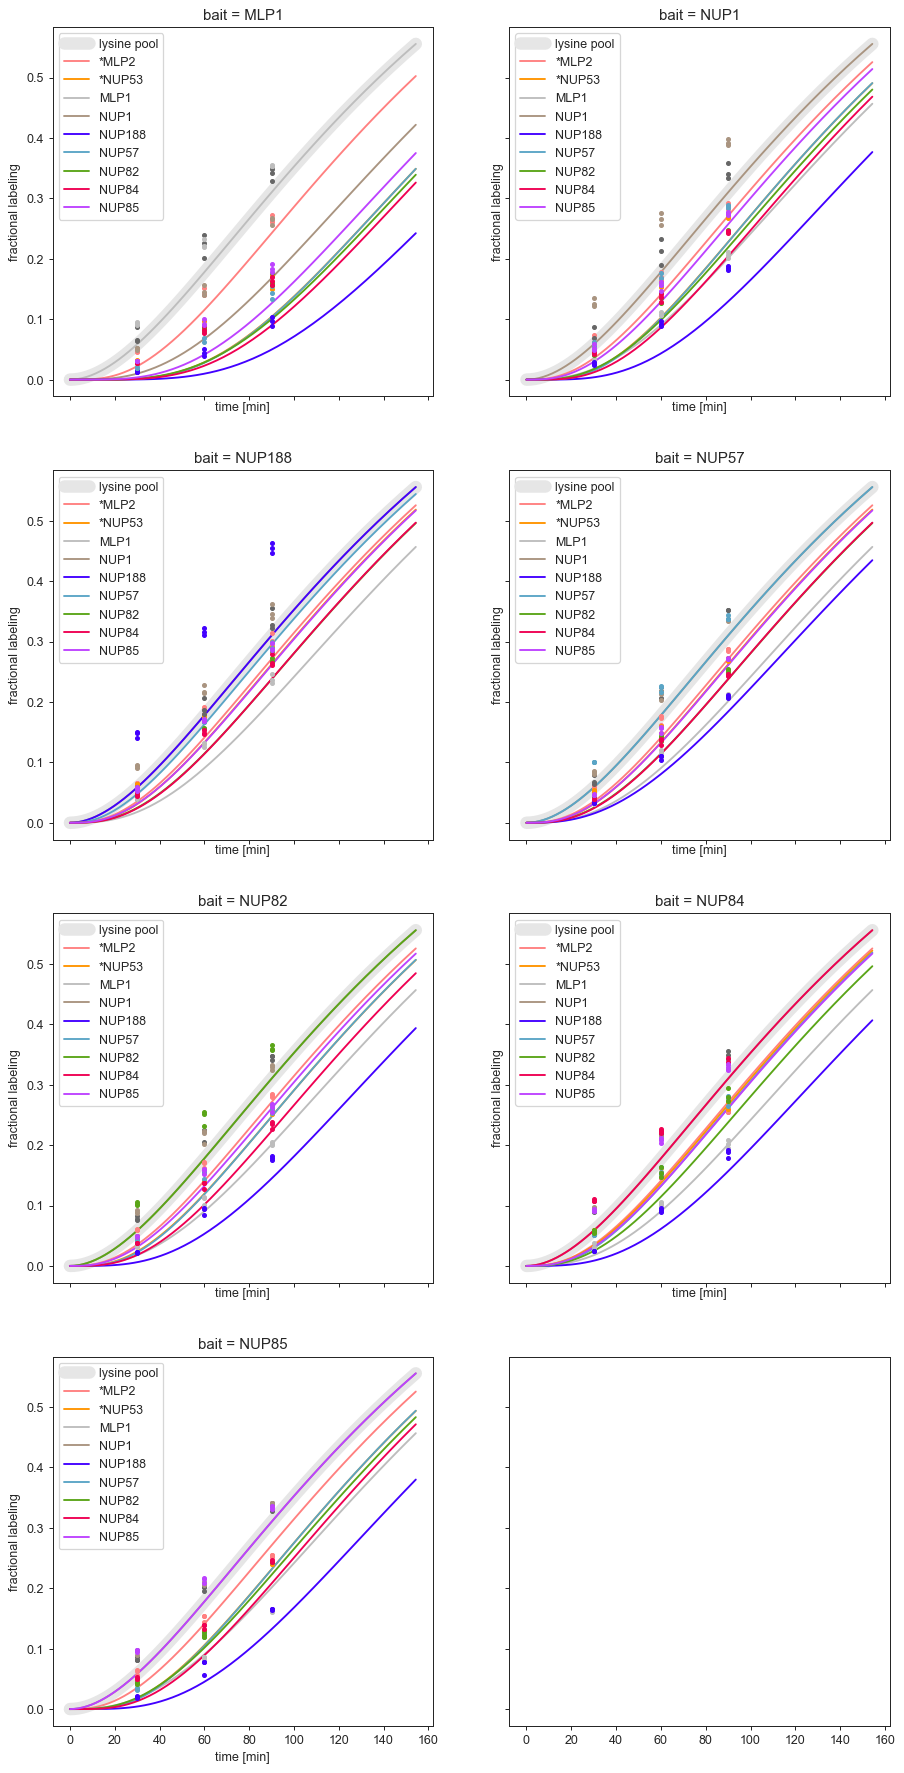

In [17]:
lysine_labeling = f_target(t_range, np.array([LYSINE_PSI, 1.]), index=1)

fig, axs = plt.subplots(4, 2, figsize=(12, 25), dpi=90, sharey=True, sharex=True)
for ax, bait in zip(axs.flat, best_tree.baits):
    ax.set_title(f"bait = {bait}")
    x = labeling_with_baits_df[labeling_with_baits_df.bait == bait]
    ax.plot(t_range, lysine_labeling, color=(0.9, 0.9, 0.9), linewidth=10, zorder=1, label="lysine pool")
    for prey, prey_df in labeling_with_baits_df[labeling_with_baits_df.bait == bait].groupby("prey"):
        ax.plot(prey_df.time, prey_df.labeling, '-', zorder=2, color=colormap[prey], label=prey)
    for prey, prey_df in clustered_data_df[clustered_data_df.bait == bait].groupby("prey"):
        ax.plot(prey_df.time, prey_df.k1, ".", zorder=2, color=colormap[prey], label=None)
    ax.set_ylabel("fractional labeling")
    ax.set_xlabel("time [min]")
    ax.legend()
fig.savefig("../res/brl1_dynamic/best_tree_full_model.pdf")

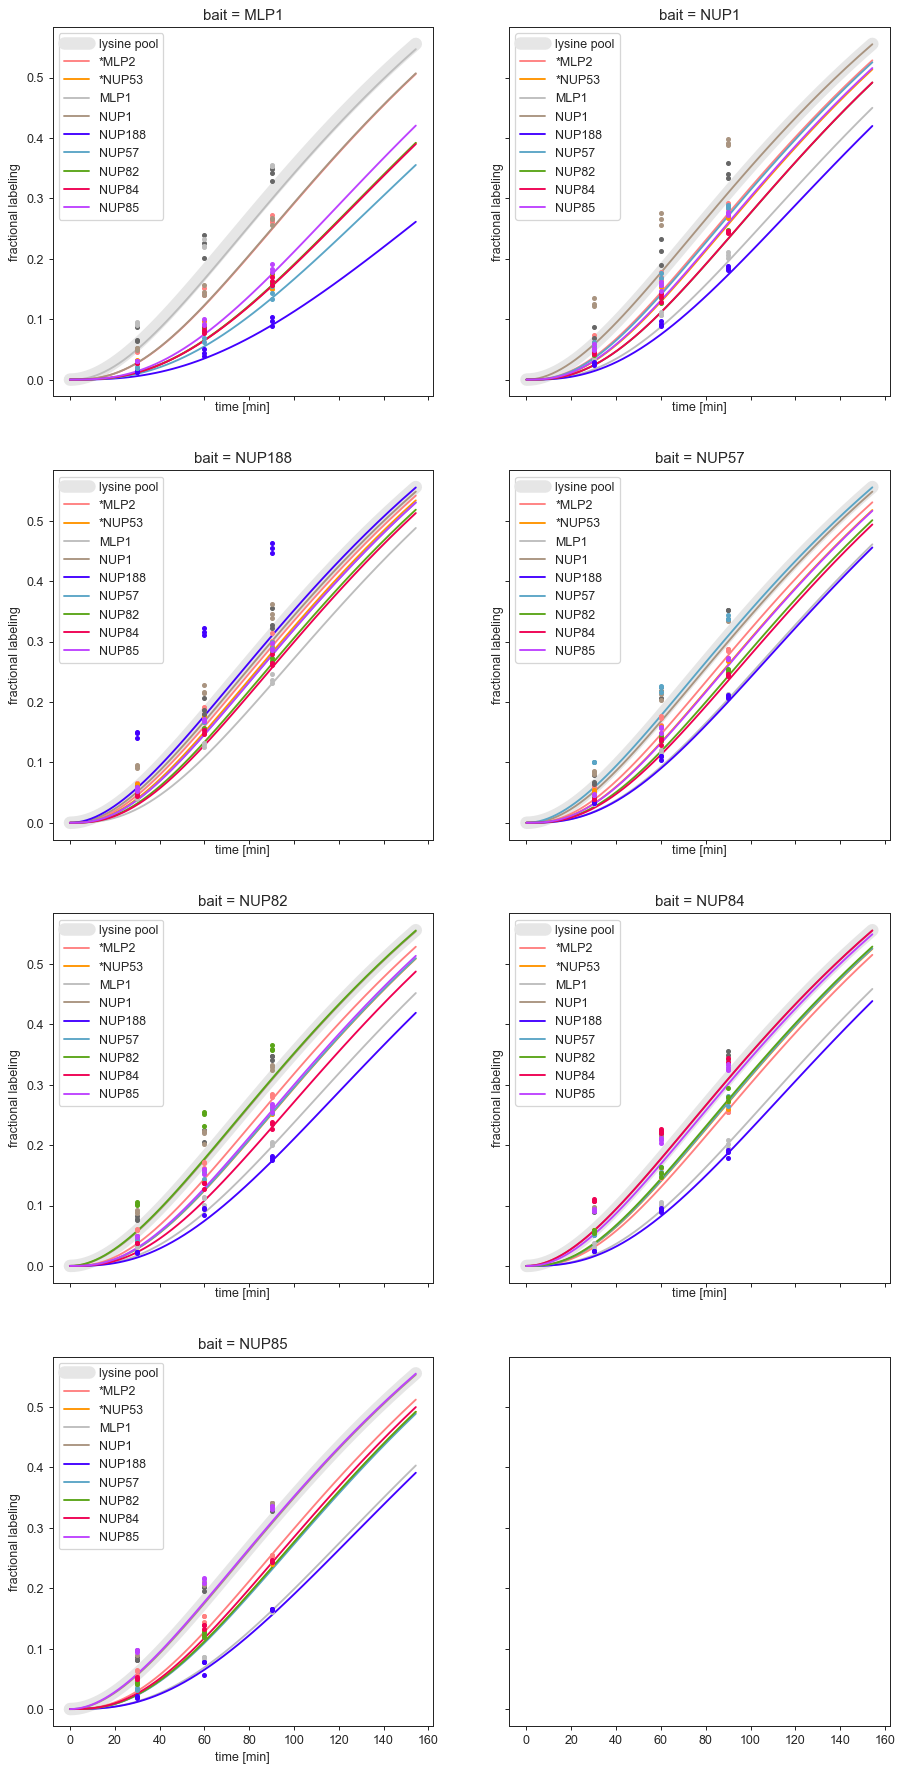

In [18]:
phi1 = clustered_ksm_df.pivot("bait", "prey", "phi1").applymap(lambda x: x.nominal_value)

fig, axs = plt.subplots(4, 2, figsize=(12, 25), dpi=90, sharey=True, sharex=True)
for ax, bait in zip(axs.flat, best_tree.baits):
    ax.set_title(f"bait = {bait}")
    x = labeling_with_baits_df[labeling_with_baits_df.bait == bait]
    ax.plot(t_range, lysine_labeling, color=(0.9, 0.9, 0.9), linewidth=10, zorder=1, label="lysine pool")
    for prey in best_tree.preys:
        labeling = f_target(
            t_range, np.array([LYSINE_PSI, phi1.at[bait, prey], 1.]), index=2
        )
        ax.plot(t_range, labeling, '-', zorder=2, color=colormap[prey], label=prey)
    for prey, prey_df in clustered_data_df[clustered_data_df.bait == bait].groupby("prey"):
        ax.plot(prey_df.time, prey_df.k1, ".", zorder=2, color=colormap[prey], label=None)
    ax.set_ylabel("fractional labeling")
    ax.set_xlabel("time [min]")
    ax.legend()
fig.savefig("../res/brl1_dynamic/best_tree_3_state_model.pdf")    